In [1]:
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from tqdm import tqdm
import clip
from models import TransformerClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
dataset = 'sdv5'
os.makedirs(f'./weights/{dataset}', exist_ok=True)
os.makedirs(f'./results/{dataset}', exist_ok=True)

In [4]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

clip_model.float()
teacher_model = TransformerClassifier().to(device)

In [5]:
train_path = f'./data/{dataset}/train'

train_folder = datasets.ImageFolder(root=train_path, transform=preprocess)

train_folder, val_folder = random_split(train_folder, [0.8, 0.2])

train_loader = DataLoader(train_folder, batch_size=64, shuffle=True)
val_loader = DataLoader(val_folder, batch_size=64, shuffle=False)

In [6]:
# _datasets = ['adm', 'biggan', 'glide', 'midjourney', 'sdv5', 'vqdm', 'wukong']

# train_folders = []
# val_folders = []

# for ds in _datasets:
# 	train_path = f'./data/{ds}/train'

# 	train_folder = datasets.ImageFolder(root=train_path, transform=preprocess)

# 	train_folder, val_folder = random_split(train_folder, [0.8, 0.2])
# 	train_folders.append(train_folder)
# 	val_folders.append(val_folder)
 
# train_folder = ConcatDataset(train_folders)
# val_folder = ConcatDataset(val_folders)

# train_loader = DataLoader(train_folder, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_folder, batch_size=16, shuffle=False)

In [7]:
# def _convert_image_to_rgb(image):
#     return image.convert("RGB")

# def _transform(n_px = 224, flip_mode = None):
#     flip = {
#         None: [],
# 		1: [transforms.RandomHorizontalFlip(p=1)],
# 		2: [transforms.RandomVerticalFlip(p=1)],
# 		3: [transforms.RandomHorizontalFlip(p=1), transforms.RandomVerticalFlip(p=1)]
# 	}
#     return transforms.Compose([
#         transforms.Resize(n_px, interpolation=transforms.InterpolationMode.BICUBIC),
#         transforms.CenterCrop(n_px),
#         *flip[flip_mode],
#         _convert_image_to_rgb,
#         transforms.ToTensor(),
#         transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
#     ])

In [8]:
# train_path = f'./data/{dataset}/train'

# train_folder = datasets.ImageFolder(root=train_path, transform=_transform())
# train_folder1 = datasets.ImageFolder(root=train_path, transform=_transform(flip_mode=1))
# train_folder2 = datasets.ImageFolder(root=train_path, transform=_transform(flip_mode=2))
# train_folder3 = datasets.ImageFolder(root=train_path, transform=_transform(flip_mode=3))

# train_folder = ConcatDataset([train_folder, train_folder1, train_folder2, train_folder3])

# train_folder, val_folder = random_split(train_folder, [0.8, 0.2])

# train_loader = DataLoader(train_folder, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_folder, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..1.9848372].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6024829..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1499318..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..1.

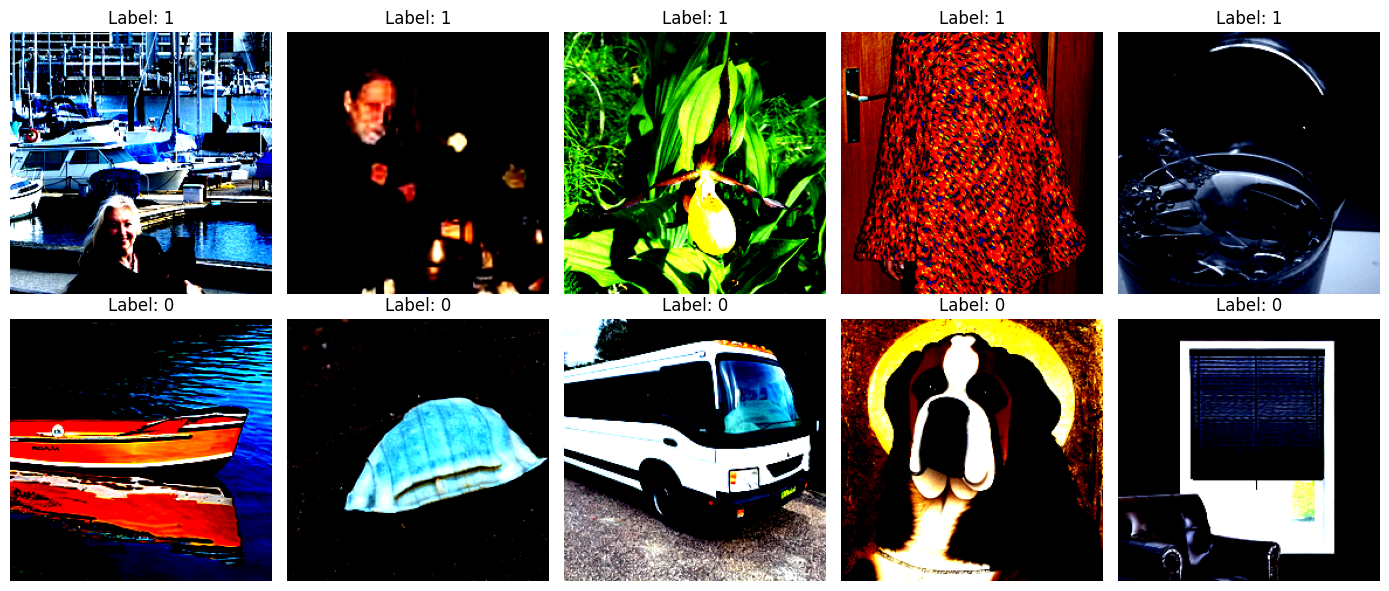

In [7]:
random_indices = np.random.choice(len(train_folder), 10, replace=False)
images, labels = zip(*[train_folder[i] for i in random_indices])

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()

for ax, img, label in zip(axes, images, labels):
	ax.imshow(img.permute(1, 2, 0).numpy())
	ax.set_title(f'Label: {label}')
	ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
num_epochs = 10

optimizer = torch.optim.AdamW(teacher_model.parameters(), lr=1e-5)

loss_fn = torch.nn.CrossEntropyLoss()

result = []

In [11]:
min_val_loss = float('inf')

for epoch in range(num_epochs):
    
    with tqdm(total=len(train_loader), desc=f'Train Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        teacher_model.train()
        running_loss = 0.0
        correct = 0
        for batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                image_features = clip_model.encode_image(images)
            logits = teacher_model(image_features)
            loss = loss_fn(logits, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            correct += (predictions == labels).sum().item()
            
            pbar.set_postfix({'loss': running_loss/(batch+1)})
            pbar.update()
            
        train_loss = running_loss/len(train_loader)
        train_acc = correct/len(train_loader.dataset)*100
        pbar.set_postfix({'loss': train_loss, 'acc': train_acc})
    
    with tqdm(total=len(val_loader), desc=f'Validation Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        teacher_model.eval()
        with torch.inference_mode():
            running_loss = 0.0
            correct = 0
            for batch, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                image_features = clip_model.encode_image(images)
                logits = teacher_model(image_features)
                
                running_loss += loss_fn(logits, labels).item()
                predictions = torch.argmax(logits, dim=-1)
                correct += (predictions == labels).sum().item()
                
                pbar.set_postfix({'loss': running_loss/(batch+1)})
                pbar.update()
                
        val_loss = running_loss/len(val_loader)
        val_acc = correct/len(val_loader.dataset)*100
        pbar.set_postfix({'loss': val_loss, 'acc': val_acc})
                
    result.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})
    result_df = pd.DataFrame(result)
    result_df.to_csv(f'./results/{dataset}/teacher.csv', index=False)
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(teacher_model.state_dict(), f'./weights/{dataset}/teacher.pth')

Train Epoch 1/10:   0%|          | 0/4050 [00:00<?, ?batch/s]c:\Users\hoang\xldl\.venv\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Train Epoch 6/10:   1%|          | 34/4050 [00:18<36:29,  1.83batch/s, loss=0.00367]


KeyboardInterrupt: 

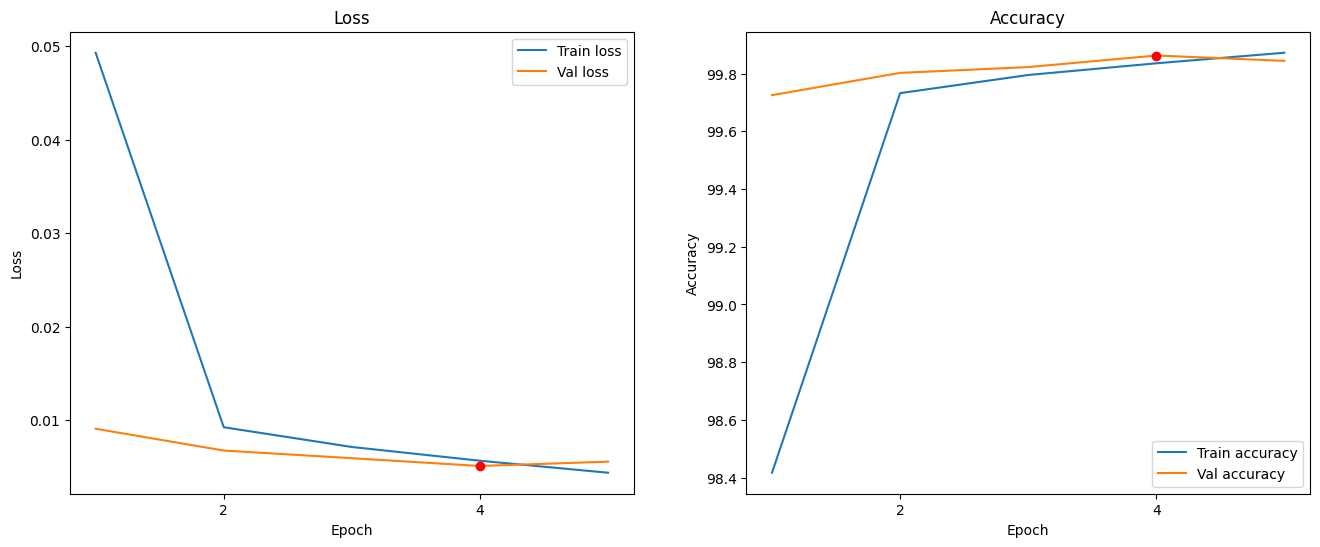

In [5]:
result = pd.read_csv(f'./results/{dataset}/teacher.csv')

min_val_loss = float('inf')
for _, row in result.iterrows():
    if row['val_loss'] < min_val_loss:
        min_val_loss = row['val_loss']
        min_val_loss_row = row
        
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(result['epoch'], result['train_loss'], label='Train loss')
ax[0].plot(result['epoch'], result['val_loss'], label='Val loss')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_xticks(result['epoch'][1::2])
ax[0].plot(min_val_loss_row['epoch'], min_val_loss_row['val_loss'], 'ro')
ax[0].legend()

ax[1].plot(result['epoch'], result['train_acc'], label='Train accuracy')
ax[1].plot(result['epoch'], result['val_acc'], label='Val accuracy')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_xticks(result['epoch'][1::2])
ax[1].plot(min_val_loss_row['epoch'], min_val_loss_row['val_acc'], 'ro')
ax[1].legend()